In [1]:
import tensorflow as tf
import os
import matplotlib.pylab as plt

# Image Data Handling

## Keras API - using TF Dataset

In [25]:
def scale_image(img):
    return img / 255.0

def to_one_hot(label):
    return tf.one_hot(label, depth=2)

IMG_HEIGHT, IMG_WIDTH = 224, 224
SEED = 420
train_dir = "./example_training_data"
test_dir = "./test_data"
batch_size = 32

training_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="training",
  labels='inferred',  
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size)

Found 294 files belonging to 2 classes.
Using 265 files for training.
Found 97 files belonging to 2 classes.


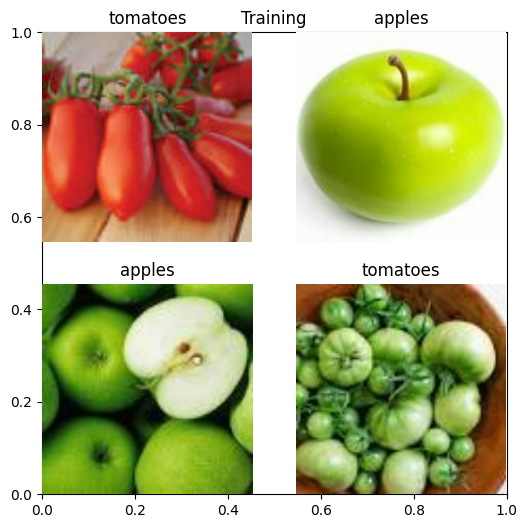

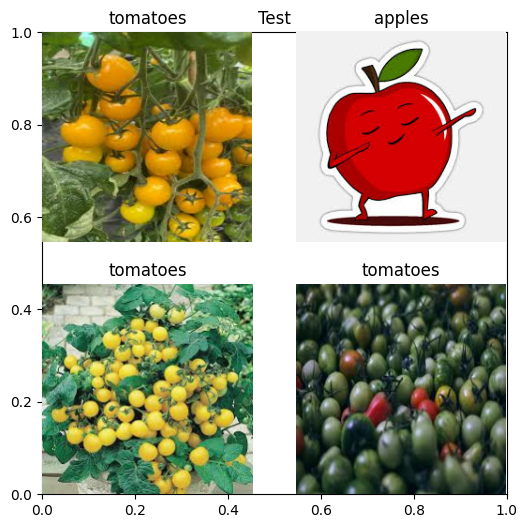

In [24]:
def show_images(images, labels, class_names, title):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, label_batch in training_data.take(1):  # Take a single batch of images
    show_images(image_batch, label_batch, training_data.class_names, "Training")
    
for image_batch, label_batch in test_data.take(1):  # Take a single batch of images
    show_images(image_batch, label_batch, test_data.class_names, "Test")

##  Tensorflow DataSet

# Model Definition

## from scratch

In [148]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    tf.keras.layers.Convolution2D(filters=16, kernel_size=(5,5)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Convolution2D(filters=32, kernel_size=(5,5)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=64, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=128, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Convolution2D(filters=256, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Flatten(),
            
    tf.keras.layers.Dense(128, activation='relu'),            
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 25, 25, 64)     

## using pre-trained model

In [181]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(2, 'softmax')
])
    
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_27 (Dense)            (None, 512)               1049088   
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dense_29 (Dense)            (None, 2)                 514       
                                                                 
Total params: 24,745,730
Trainable params: 24,700,290
Non-trainable params: 45,440
_________________________________________________________________


In [182]:
base_model.trainable = False
model.summary()
#note how the amount of trainable params is reduced

#workflow: first train only the just added dense layers, then fine tune the complete model (or only parts of the base model)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_27 (Dense)            (None, 512)               1049088   
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dense_29 (Dense)            (None, 2)                 514       
                                                                 
Total params: 24,745,730
Trainable params: 1,180,930
Non-trainable params: 23,564,800
_________________________________________________________________


# Data Augmentation and Preprocessing

- Augmentation: generate "more" training data
- Preprocessing: make data suitable for model

In [178]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [163]:
data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
])

## Option 1: add directly to model
- augmentation is automatically only used at training time
- data preprocessing and augmentation get automatic GPU support

In [164]:
model = tf.keras.Sequential([
  data_preprocessing,
  data_augmentation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  # Rest of your model.
])


## Option 2: apply on dataset
- can run in parallel to model on the CPU (does not block GPU)
- pre-processing must be done outside of model at inference time

In [ ]:
training_data = training_data.map(lambda img, label: (data_preprocessing(img, training=True), label))
training_data = training_data.map(lambda img, label: (data_augmentation(img, training=True), label))

Found 10 files belonging to 2 classes.
Using 8 files for training.


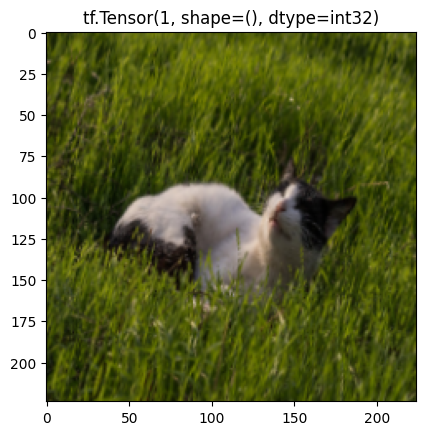

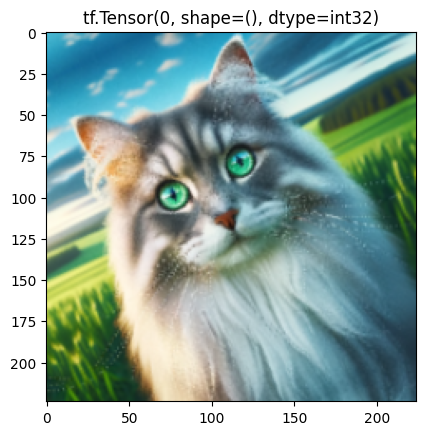

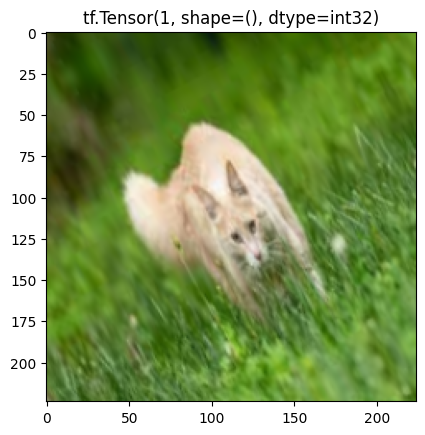

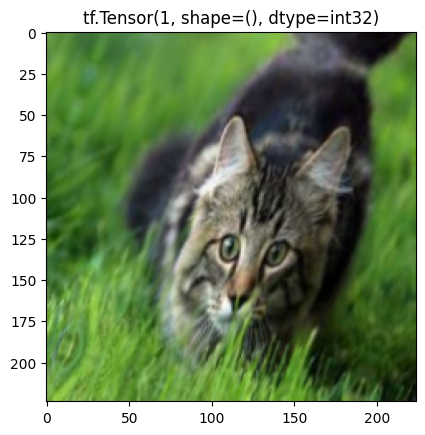

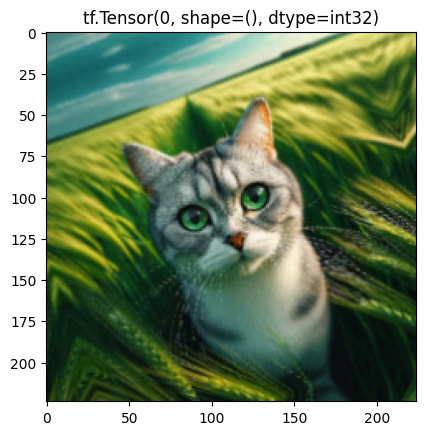

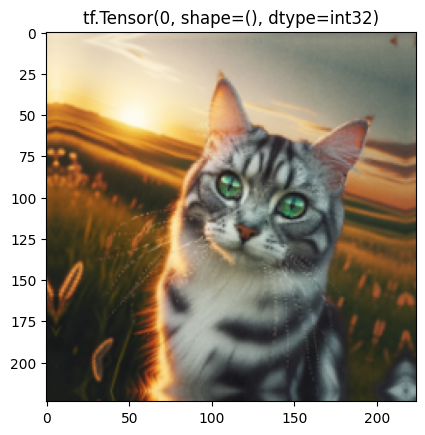

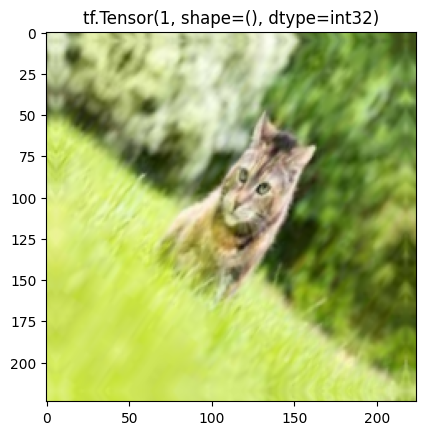

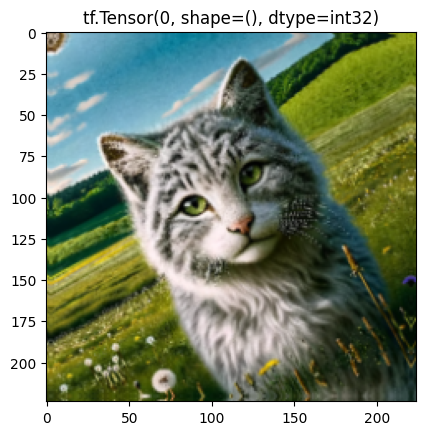

In [179]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

training_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  labels='inferred',  
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)
  
training_data = training_data.map(lambda img, label: (data_preprocessing(img, training=True), label))
training_data = training_data.map(lambda img, label: (data_augmentation(img, training=True), label))

for img, label in training_data.take(1):

    for i in range(img.shape[0]):
        plt.figure()
        plt.title(str(label[i]))
        plt.imshow(img[i, ...])

# Model Training

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Optimizer
- either a string or instance of tf.keras.optimizers
- see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

## Loss
- either a string or instance of tf.keras.losses
- see https://www.tensorflow.org/api_docs/python/tf/keras/losses
- for classification
  - use CategoricalCrossentropy when label is encoded one_hot
  - use SparseCategoricalCrossentropy when label is numeric (e.g. 0,1,2,...)
- from_logits
  - when True: assumes the last layer is *NOT* normalized (does not sum to 1)
  - when False: assume the last layer is normalized (e.g. softmax activation)

## Metrics
- list of either strings or instances of tf.keras.metrics
- see https://www.tensorflow.org/api_docs/python/tf/keras/metrics
- can also be any function `result = fn(y_true, y_pred)`
- will be evaluated automatically during training and testing


In [ ]:
epochs = 15
history = model.fit(
  training_data,
  # validation_data=validation_data,
  epochs=epochs
)

- fit the model on the training data set
- if validation_data is provided, it will calculate the loss and the metrics on it after every epoch
- returns training history, `history.history` is a dict with the loss over time
- `plt.plot(history.history['loss'])` will plot the loss of the training over the epochs

## Save and restor Model
- for saving during the training process (for fault tolerance) see
  - https://www.tensorflow.org/api_docs/python/tf/train/CheckpointManager
  - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/BackupAndRestore

In [ ]:
model.save('my_model.keras') # generates keras format
model.save('my_model.h5') # generates hdf5 format

model.export('some_dir') # creates a SavedModel (for e.g. TF Serving)

model.save_weights('some_dir') # saves only the weights of the model, not the model itself
model.load_weights('some_dir') # restores the model from the wieghts

new_model = tf.keras.models.load_model('my_model.keras') 

## Serve as HTTP Server
note: code is not tested, this are snippets from the (not terribly consistent) official documentation

please refer to the official documentation

https://github.com/tensorflow/serving

In [ ]:
model.export('model_dir/image_model/1') # creates a SavedModel (note version 1)

### install Tensorflow Serving
see https://www.tensorflow.org/tfx/guide/serving

### run TensorFlow Serving
```
tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=image_model \
  --model_base_path="./model_dir"
```

In [ ]:
import json
import requests

#test_images = ... somehow load a set of images

data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})

headers = {"content-type": "application/json"}
json_response = requests.post('http://TF_SERVING_URL:8501/v1/models/image_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']